In [24]:
# -*- coding: utf-8 -*-
import numpy as np
import random
import math
from sklearn.metrics import mean_squared_error
import time
from collections import defaultdict
from typing import List, Tuple
import os
import sys
from operator import itemgetter
import csv
from statistics import mode, median
import matplotlib.pyplot as plt
import pickle

In [2]:
# 设置字体为 SimHei黑体
plt.rcParams['font.family'] = 'SimHei'

In [3]:
train_data_path = './Data-RecommandationSystem/train.txt'
test_data_path='./Data-RecommandationSystem/test.txt'

### 对数据集进行分析

In [4]:
def data_analysis(dataPath, isTest):
    user_rating_counts = {}  # 存储每个用户的评分次数
    item_rating_counts = {}  # 存储每个物品被评分的次数
    score_counts = {}  # 存储不同评分的次数
    users = set()  # 存储所有用户ID
    items = set()  # 存储所有物品ID
    ratings = 0  # 总评分数
    minUserId = float('inf')  # 最小用户ID，初始为正无穷大
    maxUserId = 0  # 最大用户ID，初始为0
    minItemId = float('inf')  # 最小物品ID，初始为正无穷大
    maxItemId = 0  # 最大物品ID，初始为0
    dataInfo = {}  # 存储最终的统计信息

    with open(dataPath, 'r') as readStream:  
        for line in readStream:  
            if not line.strip(): 
                continue
            header = line.strip()  # 读取并去除行首尾空白字符
            sepPos = header.find("|")  # 找到分隔符的位置
            userId = int(header[:sepPos])  # 提取用户ID
            rateNum = int(header[sepPos + 1:])  # 提取评分数量
            users.add(userId)  # 将用户ID添加到集合中
            ratings += rateNum  # 增加总评分数
            minUserId = min(userId, minUserId)  # 更新最小用户ID
            maxUserId = max(userId, maxUserId)  # 更新最大用户ID
            
            # 统计用户的评分次数
            if userId in user_rating_counts:
                user_rating_counts[userId] += rateNum
            else:
                user_rating_counts[userId] = rateNum

            # 统计每个物品的评分次数和不同评分的次数
            for _ in range(rateNum):  
                if not isTest:  # 如果不是测试集
                    itemId, score = map(int, readStream.readline().strip().split())  # 读取物品ID和评分
                    if itemId in item_rating_counts:  # 如果物品ID已经存在于字典中
                        item_rating_counts[itemId] += 1  # 增加评分次数
                    else:
                        item_rating_counts[itemId] = 1  # 否则初始化评分次数为1
                    
                    if score in score_counts:# 如果当前分数已存在于字典中
                        score_counts[score] += 1# 增加分数出现次数
                    else:
                        score_counts[score] = 1 # 初始化当前分数出现次数为1
                    
                else:  # 如果是测试集
                    itemId = int(readStream.readline().strip())  # 只读取物品ID
                items.add(itemId)  # 将物品ID添加到集合中
                minItemId = min(itemId, minItemId)  # 更新最小物品ID
                maxItemId = max(itemId, maxItemId)  # 更新最大物品ID
    
    if not isTest:
        # 计算平均每个用户的评分次数和平均每个物品的评分次数
        avg_user_ratings = sum(user_rating_counts.values()) / len(user_rating_counts)
        avg_item_ratings = sum(item_rating_counts.values()) / len(item_rating_counts)
    
        # 找出评分次数最多和最少的物品
        max_rated_item = max(item_rating_counts, key=item_rating_counts.get)
        min_rated_item = min(item_rating_counts, key=item_rating_counts.get)
    
        # 找出最常见的评分和次数
        most_common_score = max(score_counts, key=score_counts.get)
        most_common_score_count = score_counts[most_common_score]
    
        # 找出最不常见的评分和次数
        least_common_score = min(score_counts, key=score_counts.get)
        least_common_score_count = score_counts[least_common_score]
        
        # 计算评分的中位数
        scores = [score for score, count in score_counts.items() for _ in range(count)]
        median_score = median(scores)
    
    # 填充统计信息
    dataInfo["userNum"] = len(users)  # 用户数
    dataInfo["itemNum"] = len(items)  # 物品数
    dataInfo["rateNum"] = ratings  # 总评分数
    dataInfo["minUserId"] = minUserId  # 最小用户ID
    dataInfo["maxUserId"] = maxUserId  # 最大用户ID
    dataInfo["minItemId"] = minItemId  # 最小物品ID
    dataInfo["maxItemId"] = maxItemId  # 最大物品ID
    
    if not isTest:
        dataInfo["avg_user_ratings"] = avg_user_ratings # 平均每个用户的评分次数
        dataInfo["avg_item_ratings"] = avg_item_ratings # 平均每个物品的评分次数
        dataInfo["max_rated_item"] = max_rated_item # 评分次数最多的物品
        dataInfo["min_rated_item"] = min_rated_item # 评分次数最少的物品
        dataInfo["most_common_score"] = most_common_score # 最常见的评分
        dataInfo["most_common_score_count"] = most_common_score_count # 最常见评分出现的次数
        dataInfo["least_common_score"] = least_common_score # 最不常见的评分
        dataInfo["least_common_score_count"] = least_common_score_count # 最不常见评分出现的次数
        dataInfo["median_score"] = median_score # 评分的中位数

    if not isTest:  # 如果不是测试集
        with open("./Data-RecommandationSystem/Long_Tail_Data.txt", 'w') as longTailData:  # 打开文件写入长尾数据
            allItemRatedTimes = [(i, item_rating_counts.get(i, 0)) for i in range(minItemId, maxItemId + 1)]  # 获取所有物品的评分次数
            allItemRatedTimes.sort(key=lambda x: x[1], reverse=True)  # 按评分次数从高到低排序
            for item in allItemRatedTimes:  # 写入每个物品的评分次数
                longTailData.write(f"{item[0]} {item[1]}\n")

    return dataInfo  # 返回统计信息

In [5]:
# 统计训练集的信息
train_result = data_analysis(train_data_path, False)
for key, value in train_result.items():
    print(key, ":", value)

userNum : 19835
itemNum : 455691
rateNum : 5001507
minUserId : 0
maxUserId : 19834
minItemId : 0
maxItemId : 624960
avg_user_ratings : 252.1556339803378
avg_item_ratings : 10.975654555389507
max_rated_item : 147073
min_rated_item : 342087
most_common_score : 0
most_common_score_count : 1535563
least_common_score : 7
least_common_score_count : 247
median_score : 50


In [6]:
# 统计测试集的信息
test_result = data_analysis(test_data_path, True)
for key, value in test_result.items():
    print(key, ":", value)

userNum : 19835
itemNum : 28242
rateNum : 119010
minUserId : 0
maxUserId : 19834
minItemId : 29
maxItemId : 624932


In [7]:
longtail_data_path = './Data-RecommandationSystem/Long_Tail_Data.txt'

In [8]:
# 长尾效应分析
def analyze_longtail(data_path, threshold):
    item_rating_counts = {}  # 存储每个物品被评分的次数

    # 读取数据并统计每个物品的评分次数
    with open(data_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            item_id, rating_count = map(int, line.strip().split())
            item_rating_counts[item_id] = rating_count

    # 按评分次数从高到低排序
    sorted_items = sorted(item_rating_counts.items(), key=lambda x: x[1], reverse=True)

    # 计算长尾部分的数据量和总数据量
    total_items = len(sorted_items)
    tail_items = [item for item in sorted_items if item[1] <= threshold]
    tail_items_count = len(tail_items)

    # 计算长尾部分的占比
    tail_ratio = tail_items_count / total_items

    # 绘制长尾效应图
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, total_items + 1), [count for _, count in sorted_items], color='blue', label='Rating Counts')
    plt.axvline(x=total_items - tail_items_count, color='red', linestyle='--', label='Tail Threshold')
    plt.title('Long Tail Effect Analysis')
    plt.xlabel('Items')
    plt.ylabel('Rating Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    return tail_ratio

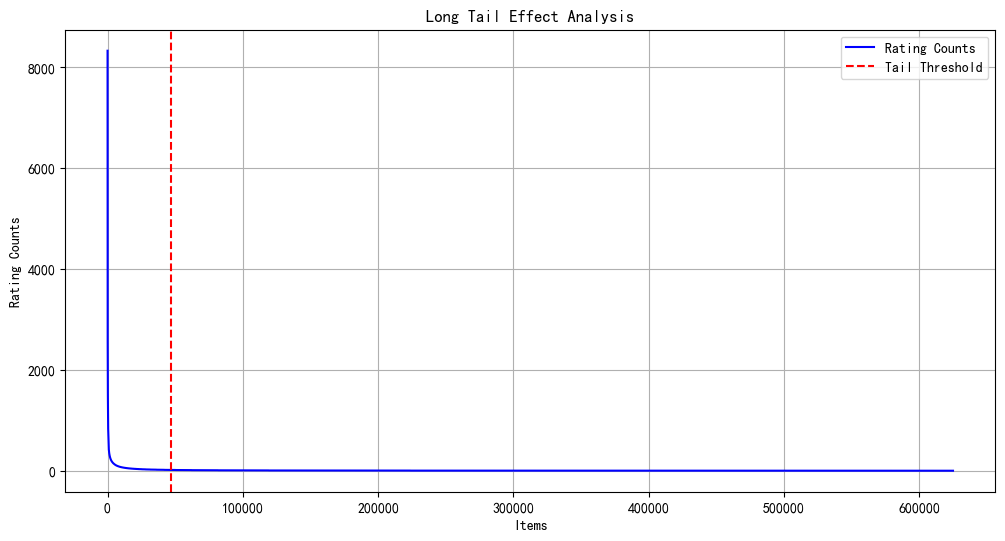

长尾部分的占比：92.4725%


In [9]:
threshold = 15  # 评分次数小于等于15次的物品属于长尾部分
tail_ratio = analyze_longtail(longtail_data_path, threshold)
print(f"长尾部分的占比：{tail_ratio:.4%}")

In [10]:
# 绘图完成用户活跃度分析，分析用户的评分次数分布
def plot_user_rating_distribution(dataPath, isTest):
    user_rating_counts = {}  # 存储每个用户的评分次数
    item_rating_counts = {}  # 存储每个物品被评分的次数
    score_counts = {}  # 存储不同评分的次数
    users = set()  # 存储所有用户ID
    items = set()  # 存储所有物品ID
    ratings = 0  # 总评分数
    minUserId = float('inf')  # 最小用户ID，初始为正无穷大
    maxUserId = 0  # 最大用户ID，初始为0
    minItemId = float('inf')  # 最小物品ID，初始为正无穷大
    maxItemId = 0  # 最大物品ID，初始为0
    dataInfo = {}  # 存储最终的统计信息

    with open(dataPath, 'r') as readStream:  
        for line in readStream:  
            if not line.strip(): 
                continue
            header = line.strip()  # 读取并去除行首尾空白字符
            sepPos = header.find("|")  # 找到分隔符的位置
            userId = int(header[:sepPos])  # 提取用户ID
            rateNum = int(header[sepPos + 1:])  # 提取评分数量
            users.add(userId)  # 将用户ID添加到集合中
            ratings += rateNum  # 增加总评分数
            minUserId = min(userId, minUserId)  # 更新最小用户ID
            maxUserId = max(userId, maxUserId)  # 更新最大用户ID
            
            # 统计用户的评分次数
            if userId in user_rating_counts:
                user_rating_counts[userId] += rateNum
            else:
                user_rating_counts[userId] = rateNum

            # 统计每个物品的评分次数和不同评分的次数
            for _ in range(rateNum):  
                if not isTest:  # 如果不是测试集
                    itemId, score = map(int, readStream.readline().strip().split())  # 读取物品ID和评分
                    if itemId in item_rating_counts:  # 如果物品ID已经存在于字典中
                        item_rating_counts[itemId] += 1  # 增加评分次数
                    else:
                        item_rating_counts[itemId] = 1  # 否则初始化评分次数为1
                    
                    if score in score_counts:# 如果当前分数已存在于字典中
                        score_counts[score] += 1# 增加分数出现次数
                    else:
                        score_counts[score] = 1 # 初始化当前分数出现次数为1
                    
                else:  # 如果是测试集
                    itemId = int(readStream.readline().strip())  # 只读取物品ID
                items.add(itemId)  # 将物品ID添加到集合中
                minItemId = min(itemId, minItemId)  # 更新最小物品ID
                maxItemId = max(itemId, maxItemId)  # 更新最大物品ID
    
    if not isTest:
        plt.figure(figsize=(10, 6))
        plt.hist(user_rating_counts.values(), bins=150, color='cyan', edgecolor='black', alpha=0.7)
        plt.title('User Rating Counts Distribution')
        plt.xlabel('Number of Ratings 评分次数')
        plt.ylabel('Number of Users 具有特定评分次数的用户数量')
        plt.grid(True)
        plt.show()

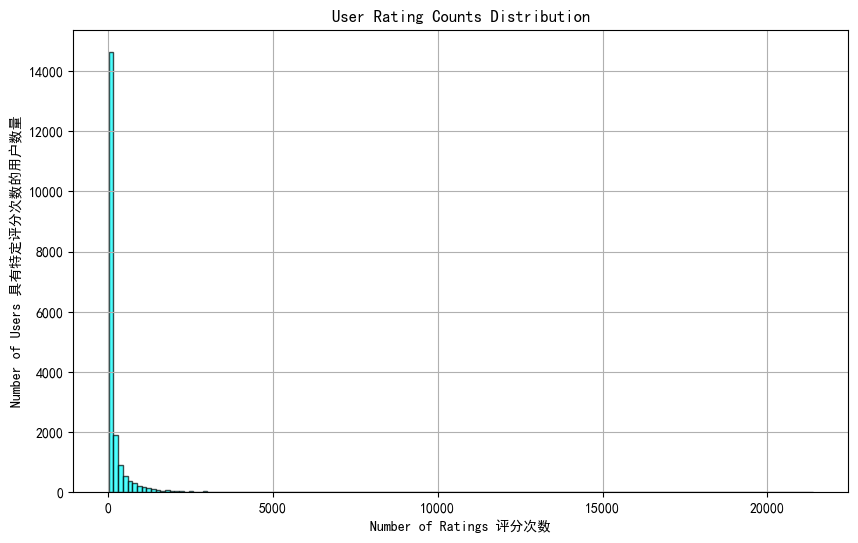

In [11]:
plot_user_rating_distribution(train_data_path, False)

In [12]:
# 绘图完成物品受欢迎程度分析，分析每个物品的评分次数分布
def plot_item_rating_distribution(dataPath, isTest):
    user_rating_counts = {}  # 存储每个用户的评分次数
    item_rating_counts = {}  # 存储每个物品被评分的次数
    score_counts = {}  # 存储不同评分的次数
    users = set()  # 存储所有用户ID
    items = set()  # 存储所有物品ID
    ratings = 0  # 总评分数
    minUserId = float('inf')  # 最小用户ID，初始为正无穷大
    maxUserId = 0  # 最大用户ID，初始为0
    minItemId = float('inf')  # 最小物品ID，初始为正无穷大
    maxItemId = 0  # 最大物品ID，初始为0
    dataInfo = {}  # 存储最终的统计信息

    with open(dataPath, 'r') as readStream:  
        for line in readStream:  
            if not line.strip(): 
                continue
            header = line.strip()  # 读取并去除行首尾空白字符
            sepPos = header.find("|")  # 找到分隔符的位置
            userId = int(header[:sepPos])  # 提取用户ID
            rateNum = int(header[sepPos + 1:])  # 提取评分数量
            users.add(userId)  # 将用户ID添加到集合中
            ratings += rateNum  # 增加总评分数
            minUserId = min(userId, minUserId)  # 更新最小用户ID
            maxUserId = max(userId, maxUserId)  # 更新最大用户ID
            
            # 统计用户的评分次数
            if userId in user_rating_counts:
                user_rating_counts[userId] += rateNum
            else:
                user_rating_counts[userId] = rateNum

            # 统计每个物品的评分次数和不同评分的次数
            for _ in range(rateNum):  
                if not isTest:  # 如果不是测试集
                    itemId, score = map(int, readStream.readline().strip().split())  # 读取物品ID和评分
                    if itemId in item_rating_counts:  # 如果物品ID已经存在于字典中
                        item_rating_counts[itemId] += 1  # 增加评分次数
                    else:
                        item_rating_counts[itemId] = 1  # 否则初始化评分次数为1
                    
                    if score in score_counts:# 如果当前分数已存在于字典中
                        score_counts[score] += 1# 增加分数出现次数
                    else:
                        score_counts[score] = 1 # 初始化当前分数出现次数为1
                    
                else:  # 如果是测试集
                    itemId = int(readStream.readline().strip())  # 只读取物品ID
                items.add(itemId)  # 将物品ID添加到集合中
                minItemId = min(itemId, minItemId)  # 更新最小物品ID
                maxItemId = max(itemId, maxItemId)  # 更新最大物品ID
    
    if not isTest:
        plt.figure(figsize=(10, 6))
        plt.hist(item_rating_counts.values(), bins=150, color='orange', edgecolor='black', alpha=0.7)
        plt.title('Item Rating Counts Distribution')
        plt.xlabel('Number of Ratings 评分次数')
        plt.ylabel('Number of Items 具有特定评分次数的项目数量')
        plt.grid(True)
        plt.show()

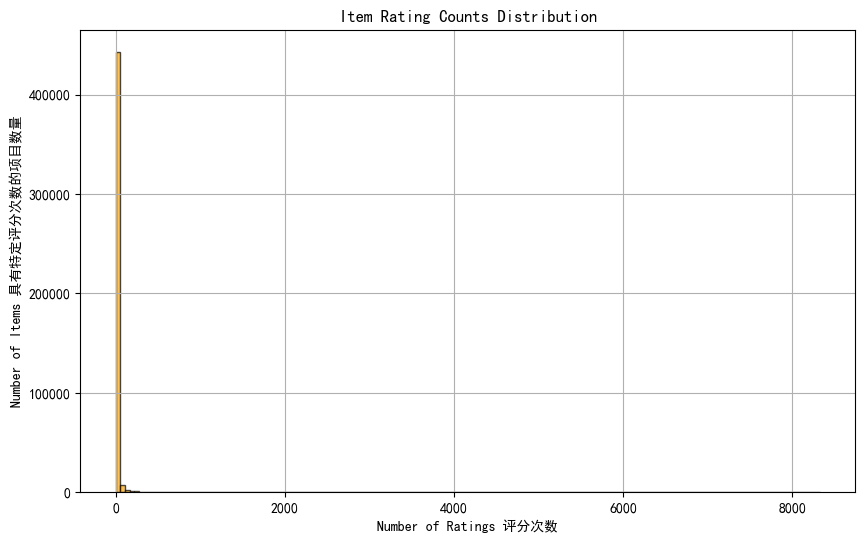

In [13]:
plot_item_rating_distribution(train_data_path, False)

### SVD++

In [108]:
class SVD_PlusPlus:
    def __init__(self, dim):
        self.dim = dim # 用户特征向量和物品特征向量的维度
        self.trainMatrix = []  # 训练集的矩阵
        self.item_rated_count = []  # 对应物品被评分的次数
        
        # 用户偏差、物品偏差、用户特征向量和物品特征向量
        self.user_bias = []
        self.item_bias = []
        self.user_features = []
        self.item_features = []
        
        self.itemInteraction = [] # 存储物品交互向量
        
        self.mean_rating = 0 # 平均评分
        self.userNum = 0 # 用户数量
        self.itemNum = 0 # 物品数量
        
    def processHeader(self, header):
        sep_pos = header.find("|")  # 找到分隔符的位置
        userId = int(header[:sep_pos])  # 提取用户ID
        rateNum = int(header[sep_pos + 1:])  # 提取评分数量
        return userId, rateNum
    
    def initialize_variables(self, lines):
        max_user_id = 0
        min_user_id = float('inf')
        max_item_id = 0
        min_item_id = float('inf')
        
        for line in lines:
            if not line.strip():
                continue
            parts = line.strip().split()
            userId, rateNum = self.processHeader(parts[0])
            minUserId = min(userId, minUserId)
            maxUserId = max(userId, maxUserId)
            
            for _ in range(rateNum):
                itemId, score = map(int, lines.pop(0).strip().split())
                minItemId = min(itemId, minItemId)
                maxItemId = max(itemId, maxItemId)
        
        return maxUserId, minUserId, maxItemId, minItemId

    def process_data(self, data_path):
        max_user_id = 0
        min_user_id = float('inf')
        max_item_id = 0
        min_item_id = float('inf')
        
        with open(data_path, 'r') as read_stream:
            for line in read_stream:
                if not line.strip(): 
                    continue
                parts = line.strip().split()
                user_id, rate_num = self.processHeader(parts[0])
                
                min_user_id = min(user_id, min_user_id)
                max_user_id = max(user_id, max_user_id)
                
                # 遍历每个用户的评分信息
                for _ in range(rate_num):
                    item_id, score = map(int, read_stream.readline().strip().split())  # 读取物品ID和评分
                    min_item_id = min(item_id, min_item_id)
                    max_item_id = max(item_id, max_item_id)
        
        # 计算用户数量和物品数量
        self.userNum = max_user_id - min_user_id + 1
        self.itemNum = max_item_id - min_item_id + 1

        # 初始化用户偏差、物品偏差、用户特征向量和物品特征向量等参数
        self.user_bias = np.zeros(self.userNum)
        self.item_bias = np.zeros(self.itemNum)
        # self.user_features = np.random.rand(self.userNum, self.dim) / self.dim
        # self.item_features = np.random.rand(self.itemNum, self.dim) / self.dim
        self.user_features = np.random.randint(low=0, high=self.dim, size=(self.userNum, self.dim)).astype(float)/ self.dim
        self.item_features = np.random.randint(low=0, high=self.dim, size=(self.itemNum, self.dim)).astype(float)/ self.dim 
        
        self.itemInteraction = np.zeros((self.itemNum, self.dim)) # 物品交互向量

        # 用户-物品评分矩阵，每一行代表一个用户，每一列代表一个物品，列表中的元素是用户对物品的评分信息
        self.trainMatrix = [[] for _ in range(self.userNum)]
        self.item_rated_count = [0] * self.itemNum # 每个元素表示对应物品被评分的次数
        self.mean_rating = 0
        
        print("Go to generate trainMatrix ...")
        self.generateTrainMatrix(data_path)
        
    def processRatings(self, stream, userId, rateNum):
        for _ in range(rateNum):
            itemId, actual_rating= map(int, stream.readline().strip().split())  # 读取物品ID和评分
        
            # 用户-物品评分矩阵，每一行代表一个用户，每一列代表一个物品，列表中的元素是用户对物品的评分信息
            self.trainMatrix[userId].append((itemId, actual_rating))# 分配到训练集
            self.mean_rating += actual_rating# 累加评分以计算平均值
            self.item_rated_count[itemId] += 1# 记录物品被评分的次数
        
    def generateTrainMatrix(self, data_path):   
        random.seed()
        train_num = 0
        
        with open(data_path, 'r') as read_stream:
            for line in read_stream:
                if not line.strip(): 
                    continue
                parts = line.strip().split()
                header = parts[0]  # 获取头部信息
                user_id, rate_num = self.processHeader(parts[0])
                self.processRatings(read_stream, user_id, rate_num)
                train_num += rate_num
                
        print("generateTrainMatrix finished ...")
        self.mean_rating /= train_num # 计算训练集评分的平均值
        self.saveTrainMatrix()
        
    def saveTrainMatrix(self):
        with open("./Data-RecommandationSystem/SVDPlusPlus_TrainMatrix.pkl", 'wb') as file:
            pickle.dump(self.trainMatrix, file)
        print("Train matrix saved ...")
    
    def init_model_parameters(self):
        random.seed()
        
        # 初始化用户偏差和物品偏差
        self.user_bias = np.zeros(self.userNum) # 初始化用户偏差为0
        self.item_bias = np.zeros(self.itemNum)  # 初始化物品偏差为0
        
        # 初始化用户特征向量 
        self.user_features = np.random.randint(low=0, high=self.dim, size=(self.userNum, self.dim)).astype(float)/ self.dim
        # self.user_features = np.random.rand(self.userNum, self.dim) / self.dim

        # 初始化物品特征向量 
        # self.item_features = np.random.rand(self.itemNum, self.dim) / self.dim
        self.item_features = np.random.randint(low=0, high=self.dim, size=(self.itemNum, self.dim)).astype(float)/ self.dim 
        
        self.itemInteraction = np.zeros((self.itemNum, self.dim))# 物品交互向量
        print("init_model_parameters finished ...")
                
    def predict_rating(self, user_id, item_id, interaction_vector):
        # 预测评分
        predicted_rating = self.mean_rating + self.user_bias[user_id] + self.item_bias[item_id] + np.dot(self.item_features[item_id], interaction_vector)
        # 限制预测评分在0到100之间
        return min(max(predicted_rating, 0), 100)
    
    def calculate_rmse(self):
        rating_count = 0 # 评分总数
        total_error = 0 # 总误差
        interaction_vector = np.zeros(self.dim) # 物品的交互向量
        
        # 预计算用户的交互向量和y值
        user_interactions = [np.zeros(self.dim) for _ in range(self.userNum)]
        y_sums = [0] * self.userNum
        
        # 遍历所有用户
        for user_id in range(self.userNum):
            rated_items = self.trainMatrix[user_id]
            if not rated_items:
                continue
                
            y_sums[user_id] = math.sqrt(len(rated_items))  # 用户评分的物品数量
                   
            # 遍历该用户评分过的所有物品，累加每个物品的交互向量
            for item_id, actual_rating in rated_items:
                user_interactions[user_id] += self.itemInteraction[item_id]
                
            # 将交互向量的每个分量除以 yj_sum，然后加上对应用户的特征向量
            user_interactions[user_id] /= y_sums[user_id]
            user_interactions[user_id] += self.user_features[user_id]
                                        
        # 遍历该用户评分过的所有物品，计算预测评分和误差
        for user_id in range(self.userNum):
            rated_items = self.trainMatrix[user_id]
            if not rated_items:
                continue
            interaction_vector = user_interactions[user_id]
            
            for item_id, actual_rating in rated_items:
                predicted_rating = self.predict_rating(user_id, item_id, interaction_vector)
                error = actual_rating - predicted_rating
                total_error += error ** 2
                rating_count += 1
        
        train_rmse = math.sqrt(total_error / rating_count)
        print(f"train RMSE: {train_rmse}")
        
    def train(self, train_file, learning_rate, regularization, epochs):
        print("--------------------- Preprocessing ---------------------")
        self.process_data(train_file)
        self.init_model_parameters()
        print("--------------------- Training ---------------------")
        
        print("epochs:", epochs)
        print("UserNum: ", self.userNum)
        t1 = time.time()
        
        interaction_vector = np.zeros(self.dim)
    
        # 遍历所有用户
        for epoch in range(1, epochs + 1):
            # self.train_epoch(learning_rate, regularization)
            # 预计算用户的交互向量和y值
            user_interactions = [np.zeros(self.dim) for _ in range(self.userNum)]
            y_sums = [0] * self.userNum
            
            for user_id in range(self.userNum):
                rated_items = self.trainMatrix[user_id]
                if not rated_items:
                    continue
                
                # 计算当前用户评分的物品数量
                y_sums[user_id] = math.sqrt(len(rated_items))  # 用户评分的物品数量
                # yj_sum = math.sqrt(len(self.trainMatrix[user_id]))
                # interaction_vector.fill(0) # 初始化交互向量为全零
            
                # 遍历该用户评分过的所有物品，累加每个物品的交互向量
                for item_id, actual_rating in self.trainMatrix[user_id]:
                    # interaction_vector += self.itemInteraction[item_id]
                    user_interactions[user_id] += self.itemInteraction[item_id]
                
                # 将交互向量的每个分量除以 yj_sum，然后加上对应用户的特征向量
                # interaction_vector /= yj_sum
                # interaction_vector += self.user_features[user_id]
                user_interactions[user_id] /= y_sums[user_id]
                user_interactions[user_id] += self.user_features[user_id]
                    
            for user_id in range(self.userNum):
                rated_items = self.trainMatrix[user_id]
                if not rated_items:
                    continue
                    
                interaction_vector = user_interactions[user_id]
                    
                # 遍历该用户评分过的物品
                for item_id, actual_rating in rated_items:
                    predicted_rating = self.predict_rating(user_id, item_id, interaction_vector)# 预测评分
                    error = actual_rating - predicted_rating # 计算误差
                
                    # 更新用户偏差项物品偏差项
                    self.user_bias[user_id] += learning_rate * (error - regularization * self.user_bias[user_id])
                    self.item_bias[item_id] += learning_rate * (error - regularization * self.item_bias [item_id])

                    # 更新用户向量和物品向量 
                    self.user_features[user_id] += learning_rate * (error * self.item_features[item_id] - regularization * self.user_features[user_id])
                    self.item_features[item_id] += learning_rate * (error * interaction_vector - regularization * self.item_features[item_id])
                    
                    # 更新物品交互向量
                    for j, _ in self.trainMatrix[user_id]:
                        self.itemInteraction[j] += learning_rate * (error * self.item_features[item_id] / y_sums[user_id] - regularization * self.itemInteraction[j])

                # 每轮每隔300个用户打印一次信息
                if user_id % 300== 0:
                    print(f"Epoch {epoch}, {user_id} users processed ...")
                    
            print(f"Epoch {epoch} finished ...")
            self.calculate_rmse()
            learning_rate *= 0.9999

        t2 = time.time()
        print(f"Training time: {t2 - t1} seconds")

    def predict(self, predict_file):
        print("--------------------- Predicting ---------------------")
        with open("./Data-RecommandationSystem/Res_SVD++.txt", 'w') as output:
            with open(predict_file, 'r') as read_stream:
                user_interactions = [np.zeros(self.dim) for _ in range(self.userNum)]
                y_sums = [0] * self.userNum
                
                # 预计算用户的交互向量和y值
                for user_id in range(self.userNum):
                    rated_items = self.trainMatrix[user_id]
                    if not rated_items:
                        continue
                    y_sums[user_id] = math.sqrt(len(rated_items))  # 用户评分的物品数量

                    for item_id, _ in rated_items:
                        user_interactions[user_id] += self.itemInteraction[item_id]

                    user_interactions[user_id] /= y_sums[user_id]
                    user_interactions[user_id] += self.user_features[user_id]    
                
                for line in read_stream:
                    parts = line.strip().split('|')
                    user_id = int(parts[0])
                    output.write(f"{user_id}|{len(parts[1:])}\n")# 写入用户ID和评分数量
                    rate_num = parts[1:]
                    # interaction_vector = np.zeros(self.dim)
                    
                    # for j, _ in self.trainMatrix[user_id]:
                        # interaction_vector += self.itemInteraction[j]
                    
                    # interaction_vector /= np.sqrt(len(self.trainMatrix[user_id]))
                    # interaction_vector += self.user_features[user_id]
                    
                    interaction_vector = user_interactions[user_id]
                    
                    for rating in range(rate_num):
                        item_id = int(read_stream.readline().strip())# 读取物品ID和评分
                        predicted_rating = self.predict_rating(user_id, item_id, interaction_vector)
                        output.write(f"{item_id} {int(predicted_rating)}\n")# 写入物品ID和预测评分
        print("Prediction finished ...")

In [109]:
# 创建一个 SVD_PlusP 的实例对象
svd_plusp = SVD_PlusPlus(20)

In [ ]:
svd_plusp.train("./Data-RecommandationSystem/train.txt", 0.001, 1.5, 20)

--------------------- Preprocessing ---------------------
Go to generate trainMatrix ...
generateTrainMatrix finished ...
Train matrix saved ...
init_model_parameters finished ...
--------------------- Training ---------------------
epochs: 20
UserNum:  19835
Epoch 1, 0 users processed ...
Epoch 1, 300 users processed ...
Epoch 1, 600 users processed ...
Epoch 1, 900 users processed ...
Epoch 1, 1200 users processed ...
Epoch 1, 1500 users processed ...
Epoch 1, 1800 users processed ...
Epoch 1, 2100 users processed ...
Epoch 1, 2400 users processed ...
Epoch 1, 2700 users processed ...
Epoch 1, 3000 users processed ...
Epoch 1, 3300 users processed ...
Epoch 1, 3600 users processed ...
Epoch 1, 3900 users processed ...


In [ ]:
# 进行预测，预测数据文件路径为 "./Data-RecommandationSystem/test.txt"
svd_plusp.predict("./Data-RecommandationSystem/test.txt")